Cargamos las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Hiperparametros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Metricas de evaluacion
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

Cargamos la bbdd

In [2]:
df = pd.read_csv("../../data/csv/df_concat_a.csv")
df = df.drop(columns="Unnamed: 0")

Equilibramos las clases

In [3]:
# Opcion 1 Undersampling
undersampler = RandomUnderSampler(random_state=16)

# Definimos target y predictoras
X = df.drop(columns=["sk_id_curr", "target"])
y = df["target"]

# Balanceamos las clases
X_balanced, y_balanced = undersampler.fit_resample(X, y)

Busqueda de hiperparametros

In [4]:
# Hacemos el train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.20, random_state=16)


# Definimos los parametros a testear en la grilla
log_params = {
    'C': [0.1, 1, 10, 100, 150],
    'solver': ['lbfgs', 'sag', 'saga'],
    'max_iter': [10, 100, 1000, 2000, 2500]
}


# Instanciamos el modelo de regresion logistica
reg = LogisticRegression()

# Realizmos el gridsearch
random_search = RandomizedSearchCV(
    reg, log_params, n_jobs=-1, cv=3, scoring="f1", verbose=True)  # Folds de validacion cruzada

# Ajustamos la grilla a la data de entrenamiento
random_search.fit(X_train, y_train)

# Obtenemos los mejores hiperparametros del modelo
best_params = random_search.best_params_

print(f"Mejores hiperparametros para la Regresion Logistica: {best_params}")


# Imprime la precisión del modelo en el conjunto de prueba
print("Precisión en test:", random_search.score(X_train, y_train))
print("Precisión en Prueba:", random_search.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparametros para la Regresion Logistica: {'solver': 'saga', 'max_iter': 2000, 'C': 100}
Precisión en test: 0.6254142054459012
Precisión en Prueba: 0.6131386861313869


In [5]:
# Instanciamos, ajustamos y aplicamos los mejores parametros
model = LogisticRegression(random_state=16)
model.set_params(**best_params)
model.fit(X_train, y_train)

# Hacemos predicciones en train y test
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Evaluacion

In [6]:
###### EVALUAMOS #########

print("===============================================================")
# Calcular la matriz de confusión TRAIN
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Matriz de Confusión: TRAIN")
print()
print(conf_matrix_train)
print()
# Imprimir el informe de clasificación TRAIN
report_train = classification_report(y_train, y_pred_train)
print("Informe de Clasificación: TRAIN")
print(report_train)

# Calcular AUC-ROC / AUC-PR TRAIN
roc_train = roc_auc_score(y_train, y_pred_train)
pr_train = average_precision_score(y_train, y_pred_train)

print(f"AUC-ROC para TRAIN : {round(roc_train,3)}")
print(f"AUC-PR para TRAIN : {round(pr_train,3)}")


print("===============================================================")


# Calcular la matriz de confusión TEST
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Matriz de Confusión: TEST")
print()
print(conf_matrix_test)
print()
# Imprimir el informe de clasificación TEST
report_test = classification_report(y_test, y_pred_test)
print("Informe de Clasificación: TEST")
print(report_test)

# Calcular AUC-ROC / AUC-PR TEST
roc_test = roc_auc_score(y_test, y_pred_test)
pr_test = average_precision_score(y_test, y_pred_test)

print(f"AUC-ROC para TEST : {round(roc_test,3)}")
print(f"AUC-PR para TEST : {round(pr_test,3)}")

Matriz de Confusión: TRAIN

[[7764 5633]
 [4767 8682]]

Informe de Clasificación: TRAIN
              precision    recall  f1-score   support

           0       0.62      0.58      0.60     13397
           1       0.61      0.65      0.63     13449

    accuracy                           0.61     26846
   macro avg       0.61      0.61      0.61     26846
weighted avg       0.61      0.61      0.61     26846

AUC-ROC para TRAIN : 0.613
AUC-PR para TRAIN : 0.569
Matriz de Confusión: TEST

[[1962 1420]
 [1230 2100]]

Informe de Clasificación: TEST
              precision    recall  f1-score   support

           0       0.61      0.58      0.60      3382
           1       0.60      0.63      0.61      3330

    accuracy                           0.61      6712
   macro avg       0.61      0.61      0.61      6712
weighted avg       0.61      0.61      0.60      6712

AUC-ROC para TEST : 0.605
AUC-PR para TEST : 0.559


Graficamos

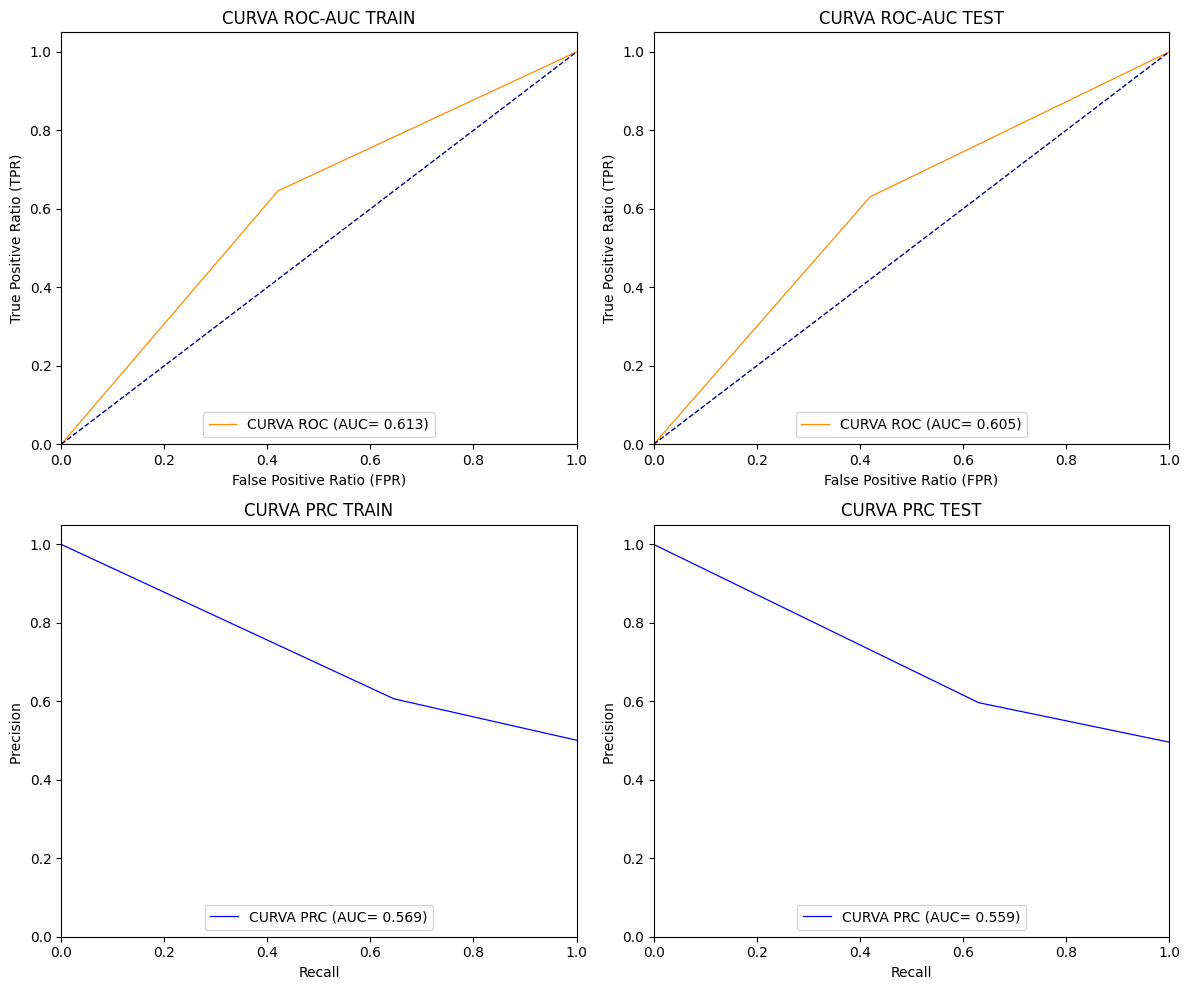

In [8]:
# Calculamos las tasas de falsos positivos (FPR) y de verdaderos positivos (TPR) para AUC-ROC


fpr_train, tpr_train, thresholds_roc_train = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, thresholds_roc_test = roc_curve(y_test, y_pred_test)

# Calculamos precision y recall para graficar AUC-PR

precision_train, recall_train, thresholds_prc_train = precision_recall_curve(
    y_train, y_pred_train)
precision_test, recall_test, thresholds_prc_test = precision_recall_curve(
    y_test, y_pred_test)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))


# AUC-ROC TRAIN
axs[0, 0].plot(fpr_train, tpr_train, color="darkorange", lw=0.9,
               label="CURVA ROC (AUC= %0.3f)" % roc_train)
axs[0, 0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel("False Positive Ratio (FPR)")
axs[0, 0].set_ylabel("True Positive Ratio (TPR)")
axs[0, 0].set_title("CURVA ROC-AUC TRAIN")
axs[0, 0].legend(loc="lower center")

# AUC-ROC TEST
axs[0, 1].plot(fpr_test, tpr_test, color="darkorange", lw=0.9,
               label="CURVA ROC (AUC= %0.3f)" % roc_test)
axs[0, 1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlabel("False Positive Ratio (FPR)")
axs[0, 1].set_ylabel("True Positive Ratio (TPR)")
axs[0, 1].set_title("CURVA ROC-AUC TEST")
axs[0, 1].legend(loc="lower center")

# AUC-PR TRAIN
axs[1, 0].plot(recall_train, precision_train, color="blue",
               lw=0.9, label="CURVA PRC (AUC= %0.3f)" % pr_train)
axs[1, 0].set_xlim([0.0, 1.0])
axs[1, 0].set_ylim([0.0, 1.05])
axs[1, 0].set_xlabel("Recall")
axs[1, 0].set_ylabel("Precision ")
axs[1, 0].set_title("CURVA PRC TRAIN")
axs[1, 0].legend(loc="lower center")

# AUC-PR TEST
axs[1, 1].plot(recall_test, precision_test, color="blue",
               lw=0.9, label="CURVA PRC (AUC= %0.3f)" % pr_test)
axs[1, 1].set_xlim([0.0, 1.0])
axs[1, 1].set_ylim([0.0, 1.05])
axs[1, 1].set_xlabel("Recall")
axs[1, 1].set_ylabel("Precision ")
axs[1, 1].set_title("CURVA PRC TEST")
axs[1, 1].legend(loc="lower center")

plt.tight_layout()
plt.show()